In [38]:
import json
import pandas as pd
from equipartition import Equipartition
import matplotlib.pyplot as plt

from astropy import units as u, constants as c

wtn_z = 0.049

# First, read in the files with the literature best-fit parameters

In [48]:
lit = pd.read_csv("lit_sed_params.csv", comment="#")
bhmasses = pd.read_csv("bh_masses_host.txt", sep="\t")
bhmasses["name"] = bhmasses.name.str.strip()

lit

,Name,t,p,epsilon_e,epsilon_B,nu_a,nu_a_error,nu_m,nu_m_error,Fp_mJy,Fp_mJy_error,dist_Mpc,z
0,CNSSJ0019+00,573,3.3,0.1,0.100,4.260000,0.040000,-99.990000,-99.990000,8.270000,0.030,77.1,0.0180
1,CNSSJ0019+00,606,3.3,0.1,0.100,3.870000,0.030000,-99.990000,-99.990000,8.080000,0.040,77.1,0.0180
2,CNSSJ0019+00,731,3.3,0.1,0.100,3.120000,0.040000,-99.990000,-99.990000,7.410000,0.060,77.1,0.0180
3,CNSSJ0019+00,998,3.3,0.1,0.100,1.920000,0.060000,-99.990000,-99.990000,4.950000,0.090,77.1,0.0180
4,ASASSN-14li,128,3.0,0.1,0.100,16.800000,0.000000,-99.990000,-99.990000,1.910000,0.000,90.0,0.0206
5,ASASSN-14li,143,3.0,0.1,0.100,8.200000,0.100000,-99.990000,-99.990000,1.760000,0.010,90.0,0.0206
6,ASASSN-14li,207,3.0,0.1,0.100,4.370000,0.200000,-99.990000,-99.990000,1.230000,0.030,90.0,0.0206
7,ASASSN-14li,246,3.0,0.1,0.100,4.000000,0.060000,-99.990000,-99.990000,1.140000,0.010,90.0,0.0206
8,ASASSN-14li,304,3.0,0.1,0.100,2.550000,0.060000,-99.990000,-99.990000,0.940000,0.020,90.0,0.0206
9,ASASSN-14li,381,3.0,0.1,0.100,1.910000,0.070000,-99.990000,-99.990000,0.620000,0.020,90.0,0.0206


# Now, use the Equipartition class to compute physical properties of the system

In [49]:
# need to compute
# Req, energyeq, magField, Ne, CNMnumDens and betaeqN

res = []
for name, grp in lit.groupby("Name"):

    if name == "SwJ1644+57":
        # then this is an on-axis jet
        eq = Equipartition(
            grp.Fp_mJy.values,
            grp.nu_a/10,
            grp.t,
            z = grp.z.values[0],
            theta = 0,
            p=grp.p,
            epse=0.1, 
            fOmega=4,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=True,
            hotprotons=True
        )
    else:
        eq = Equipartition(
            grp.Fp_mJy.values,
            grp.nu_a/10,
            grp.t,
            z = grp.z.values[0],
            theta = 0,
            p=grp.p,
            epse=0.1, 
            fOmega=4,
            fA=1, 
            fV=0.36, 
            newtonian=True, 
            isoNewtonianNe=True,
            corr=True, 
            outofequipartition=False, 
            factorsFour=True,
            hotprotons=True
        )
    
    grp["gammabeta"] = eq.gammaBeta()
    grp["Req"] = eq.Req()
    grp["Eeq"] = eq.energyeq()
    grp["B"] = eq.magField()
    grp["Ne"] = eq.Ne()
    grp["number_density"] = eq.CNMnumDens()
    res.append(grp)

eq_res = pd.concat(res)

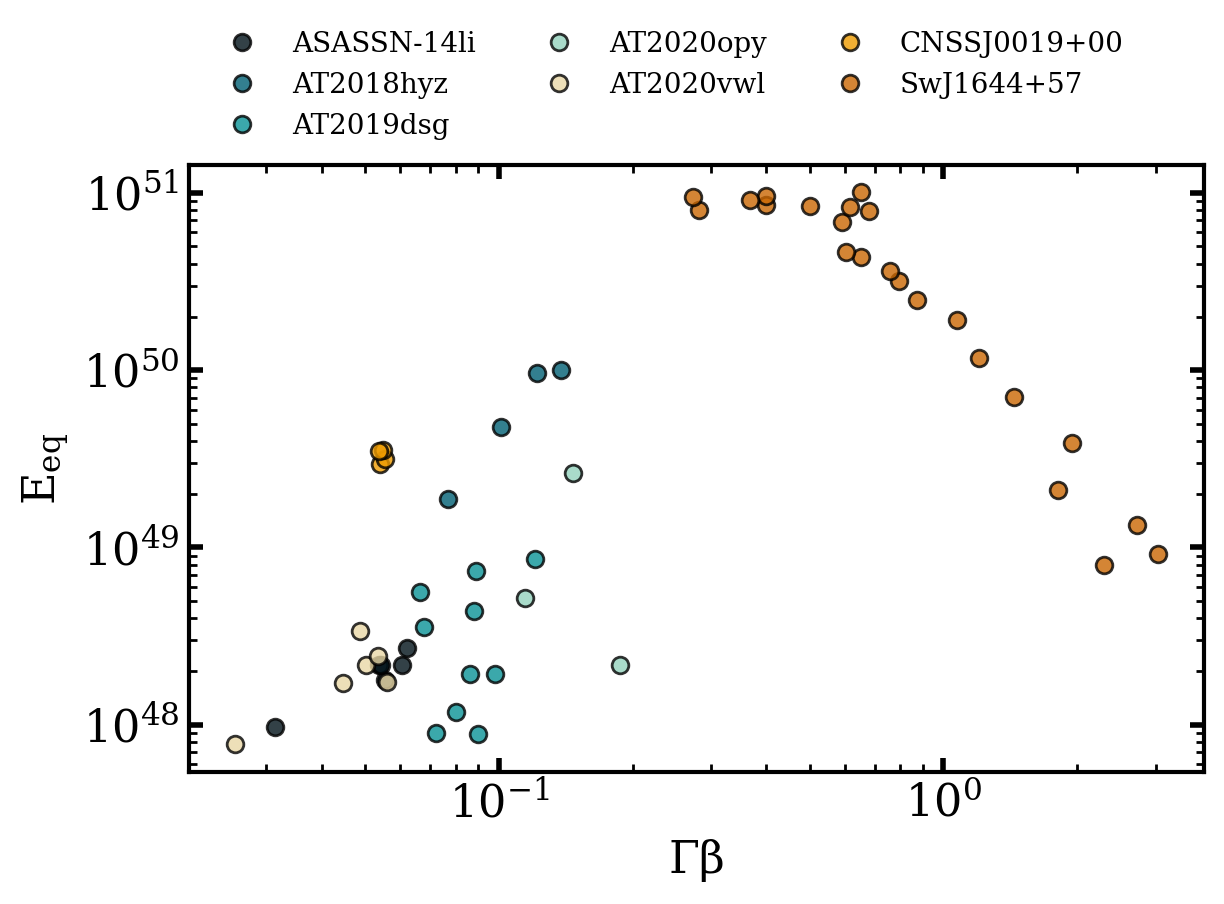

In [50]:
# energy vs gammabeta plot
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("Name"):
    ax.plot(
        grp.gammabeta,
        grp.Eeq,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$E_{eq}$")
ax.set_xlabel(r"$\Gamma \beta$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

ASASSN-14li
AT2018hyz
AT2019dsg
AT2020opy
AT2020vwl
CNSSJ0019+00
SwJ1644+57


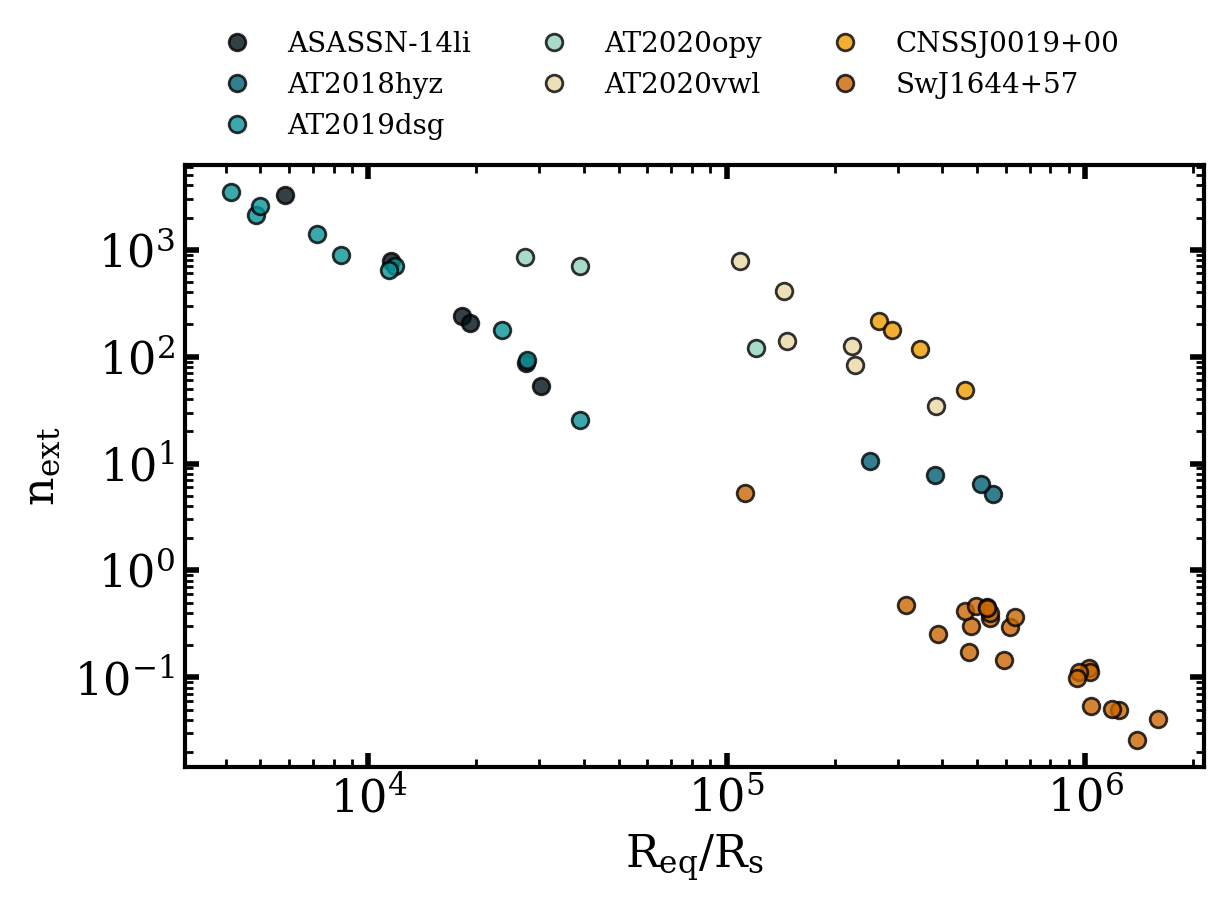

In [52]:
# density vs. radius
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("Name"):
    print(name)
    Mbh = 10**(bhmasses[bhmasses.name == name].bhmass.values[0]) * u.M_sun
    Rs = (2*c.G*Mbh / c.c**2).cgs.value
    ax.plot(
        grp.Req/Rs,
        grp.number_density,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$n_{ext}$")
ax.set_xlabel(r"$R_{eq} / R_{s}$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

In [47]:
bhmasses.name

0      ASASSN-14ae
1      ASASSN-14li
2         iPTF15af
3      ASASSN-15oi
4        iPTF16axa
5          PS16dtm
6        AT2016fnl
7        AT2017eqx
8         AT2018zr
9        AT2018bsi
10       AT2018dyb
11       AT2018hco
12       AT2018hyz
13       AT2018lna
14     ASASSN-19bt
15       AT2019azh
16       AT2019dsg
17       AT2019ehz
18       AT2019eve
19       AT2019qiz
20       AT2019teq
21        AT2020pj
22       AT2020mot
23       AT2020neh
24       AT2020nov
25       AT2020opy
26       AT2020wey
27       AT2020vwl
28       AT2018fyk
29    CNSSJ0019+00
30     SwJ1644+57 
Name: name, dtype: object